## 固定风格任意内容的快速风格迁移

**daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models

### 定义转换网络

1: 定义ResidualBlock残差块结构

2:定义图像转换网络

In [3]:
## ResidualBlock残差块的网络结构
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        ## channels:b表示要输入的feature map 数量
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1)
        )

    def forward(self, x):
        return F.relu(self.conv(x) + x)

In [4]:
## 定义图像转换网络
class ImfwNet(nn.Module):
    def __init__(self):
        super(ImfwNet, self).__init__()
        self.downsample = nn.Sequential(
            nn.ReflectionPad2d(padding=4),##使用边界反射填充
            nn.Conv2d(3,32,kernel_size=9,stride=1),
            nn.InstanceNorm2d(32,affine=True),## 在像素值上做归一化
            nn.ReLU(),  ## 3*256*256->32*256*256
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),  ## 32*256*256 -> 64*128*128
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(64,128,kernel_size=3,stride=2),
            nn.InstanceNorm2d(128,affine=True),
            nn.ReLU(),  ## 64*128*128 -> 128*64*64
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
        )
        self.unsample = nn.Sequential(
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),  ## 128*64*64->64*128*128
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),  ## 64*128*128->32*256*256
            nn.ConvTranspose2d(32,3,kernel_size=9,stride=1,padding=4),## 32*256*256->3*256*256; 
        )
    def forward(self,x):
        x = self.downsample(x) ## 输入像素值－2.1～2.7之间
        x = self.res_blocks(x)
        x = self.unsample(x) ## 输出像素值－2.1～2.7之间
        return x


In [5]:
fwnet = ImfwNet()
fwnet

ImfwNet(
  (downsample): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): ReLU()
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResidualBlock(
      (conv): Sequential(
        (0)

### 数据准备

使用COCO val2014数据集，约有40000多张图像，为了加快训练速度，节省训练时间，不使用全部的COCO2014数据集，只使用部分图像用于训练网络。


In [6]:
## 数据准备
## 定义图像的操作过程
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),# 每张图像的尺寸为256*256
    transforms.ToTensor(), ## 像素值转化到0～1
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
    ## 像素值转化到－2.1～2.7
])
## 从文件夹中读取数据
dataset = ImageFolder("data/COCO", transform=data_transform)
# 每个batch使用4张图像
data_loader = Data.DataLoader(dataset, batch_size=4, num_workers=4,shuffle=True)
dataset

Dataset ImageFolder
    Number of datapoints: 40504
    Root location: data/COCO

In [7]:
## 读取已经预训练的VGG16网络
vgg16 = models.vgg16(pretrained=True)
## 不需要网络的分类器，只需要卷积和池化层
vgg = vgg16.features.eval()
# # # 将VGG16的特征提取网络权重冻结，在训练时不更新
# for param in vgg.parameters():
#     param.requires_grad_(False)

## 输出vgg
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [7]:
## 定义一个读取风格图像或内容图像的函数，并且将图像进行必要转化
def load_image(img_path,shape=None):
    image = Image.open(img_path).convert('RGB')
    size = image.size
    ## 如果指定了图像的尺寸，就将图像转化为shape指定的尺寸
    if shape is not None:
        size = shape
    ## 使用transforms将图像转化为张量，并进行标准化
    in_transform = transforms.Compose(
        [transforms.Resize(size), # 图像尺寸变换
         transforms.ToTensor(), # 数组转化为张量
         ## 图像进行标准化
         transforms.Normalize((0.485, 0.456, 0.406), 
                              (0.229, 0.224, 0.225))])
    # 使用图像的RGB通道，并且添加batch纬度
    image = in_transform(image)[:3,:,:].unsqueeze(dim=0)   
    return image

# 定义一个将标准化后的图像转化为便于利用matplotlib可视化的函数
def im_convert(tensor):
    """ 
    将[1, c, h, w]纬度的张量转化为[ h, w,c]的数组
    因为张量进行了表转化，所以要进行标准化逆变换
    """
    image = tensor.data.numpy().squeeze() # 去处batch纬度数据
    image = image.transpose(1,2,0) ## 置换数组的纬度[c,h,w]->[h,w,c]
    ## 进行标准化的逆操作
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) ##  将图像的取值剪切到0～1之间
    return image

style shape: torch.Size([1, 3, 256, 256])


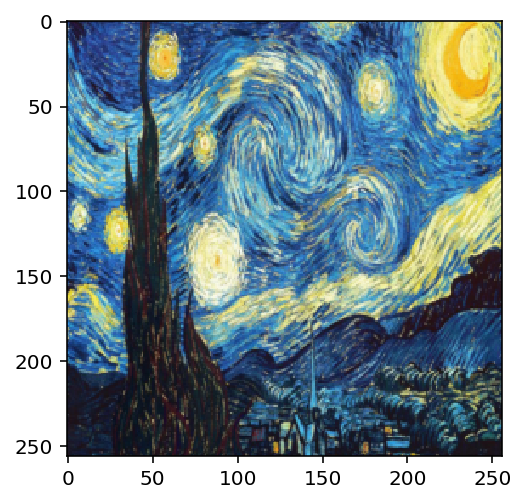

In [9]:
# 读取风格图像
style = load_image("data/chap9/tar21.png",shape=(256,256))
print("style shape:",style.shape)
## 可视化图像
plt.figure()
plt.imshow(im_convert(style))
plt.show()

In [ ]:
print(style.min())
print(style.max())

In [10]:
## 定义计算格拉姆矩阵
def gram_matrix(tensor):
    """ 
    计算指定向量的Gram Matrix，该矩阵表示了图像的风格特征，
    格拉姆矩阵最终能够在保证内容的情况下，进行风格的传输。
    tensor:是一张图像前向计算后的一层特征映射
    """
    # 获得tensor的batch_size, channel, height,  width
    b, c, h, w = tensor.size()
    # 该变矩阵的纬度为（深度，高＊宽）
    tensor = tensor.view(b,c, h * w)
    tensor_t = tensor.transpose(1,2)
    # 计算gram matrix,针对多张图像进行计算
    gram = tensor.bmm(tensor_t) / (c*h*w)
    return gram

In [11]:
## 定义一个函数，用于获取图像在网络上指定层的输出
def get_features(image, model, layers=None):
    """
    将一张图像image在一个网络model中进行前向传播计算，并获取指定层layers中的特征输出
    """
    ## TODO: 将PyTorch的VGGNet的完整映射层名称与论文中的名称相对应
    ## layers参数指定：需要用于图像的内容和样式表示的图层
    ## 如果layers没有指定，就使用默认的层
    if layers is None:
        layers = {"3": "relu1_2",
                  "8": "relu2_2", 
                  "15": "relu3_3", ## 内容图层的表示
                  "22": "relu4_3"} #经过relu激活后的输出
    features = {} ## 获取的每层特征保存到字典中
    x = image  ## 需要获取特征的图像
    # model._modules是一个字典，保存着网络model每层的信息
    for name, layer in model._modules.items():
        ## 从第一层开始获取图像的特征
        x = layer(x)
        ## 如果是layers参数指定的特征，那就保存到feature中
        if name in layers:
            features[layers[name]] = x
    return features


In [12]:
## 计算风格图像的风格表示
style_layer = {"3":"relu1_2","8":"relu2_2","15":"relu3_3","22":"relu4_3"}
content_layer = {"15": "relu3_3"}  ## 内容表示的图层，均使用经过relu激活后的输出
style_features = get_features(style, vgg,layers=style_layer)
# 为我们的风格表示计算每层的格拉姆矩阵，使用字典保存
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

### 网络训练 由于耗费时间过长这里就不训练了

In [ ]:
## 网络训练，定义三种损失的权重
style_weight = 1e5
content_weight = 1
tv_weight = 1e-5
## 定义优化器
optimizer = optim.Adam(fwnet.parameters(), lr=1e-3)
# vgg.eval()  ## 损失网络VGG16
fwnet.train()
since = time.time()
for epoch in range(4):
    print("Epoch: {}".format(epoch+1))
    for step,batch in enumerate(data_loader):
        optimizer.zero_grad()
        
        # 计算内容图像使用图像转换网络得到的输出
        content_images = batch[0]
        transformed_images = fwnet(content_images)
        transformed_images = transformed_images.clamp(-2.1, 2.7)

        # 使用 vgg16 计算特征
        content_features = get_features(content_images,vgg,layers=content_layer)
        # 计算y_hat图像对应的VGG特征
        transformed_features = get_features(transformed_images,vgg)

        # 内容损失
        content_loss = F.mse_loss(transformed_features["relu3_3"], content_features["relu3_3"])
        content_loss = content_weight*content_loss

        # total variation loss 图像水平和垂直平移一个像素，与原图相减，然后计算绝对值的和
        y = transformed_images
        tv_loss = (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                   torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))
        tv_loss = tv_weight*tv_loss

        # 风格损失
        style_loss = 0.
        transformed_grams = {layer: gram_matrix(transformed_features[layer])
                             for layer in transformed_features}
        for layer in style_grams:
            transformed_gram = transformed_grams[layer] # 是针对一个batch图像的Gram
            style_gram = style_grams[layer]   # 是针对一张图像的所以要扩充style_gram 
            style_loss += F.mse_loss(transformed_gram,
                                     style_gram.expand_as(transformed_gram))
        style_loss = style_weight*style_loss

        # 3个损失加起来
        loss = style_loss + content_loss + tv_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        if step % 2000 == 0:
            print("step:{}; content loss: {:.3f}; style loss:{:.3f};tv loss:{:.3f};loss:{:.3f}".format(
                step,content_loss.item(),style_loss.item(),tv_loss.item(),loss.item()))
            time_use = time.time() - since
            print("Train complete in {:.0f}m {:.0f}s".format(
                time_use // 60, time_use % 60))
            ## 可视化一张图像
            plt.figure()
            im = transformed_images[1,...]
            plt.imshow(im_convert(im))
            plt.show()
                
                
## 保存训练好的网络fwnet
torch.save(fwnet,"data/chap9/imfwnet_cpu.pkl")

### 测试网络的效果

In [ ]:
fwnet.eval()
##  从数据中获取一个batch的图片
for step,batch in enumerate(data_loader):
    content_images = batch[0]
    if step > 0:
        break
    print(content_images.shape)

In [ ]:
transformed_images = fwnet(content_images)
transformed_images = transformed_images.clamp(-2.1, 2.7)
print(transformed_images.shape)

In [ ]:
plt.figure(figsize=(16,4))
for ii in range(4):
    im = content_images[ii,...]
    plt.subplot(1,4,ii+1)
    plt.imshow(im_convert(im))
    
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
for ii in range(4):
    im = transformed_images[ii,...]
    plt.subplot(1,4,ii+1)
    plt.imshow(im_convert(im))
plt.show()

### 导入使用GPU训练的网络，并对图像进行风格迁移

content shape: torch.Size([1, 3, 256, 256])


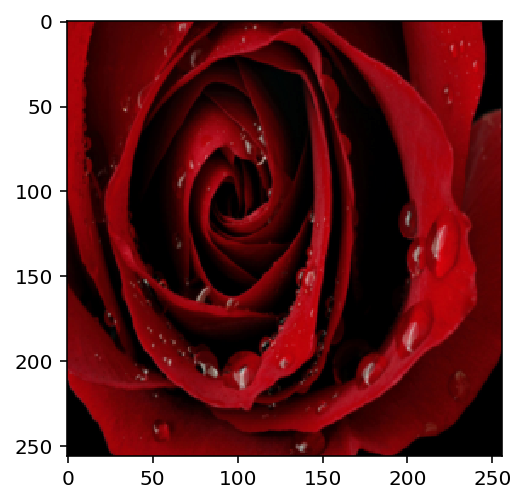

In [13]:
# 读取内容图像
content= load_image("data/chap9/tar9.png",shape = (256,256))
print("content shape:",content.shape)
## 可视化图像
plt.figure()
plt.imshow(im_convert(content))
plt.show()

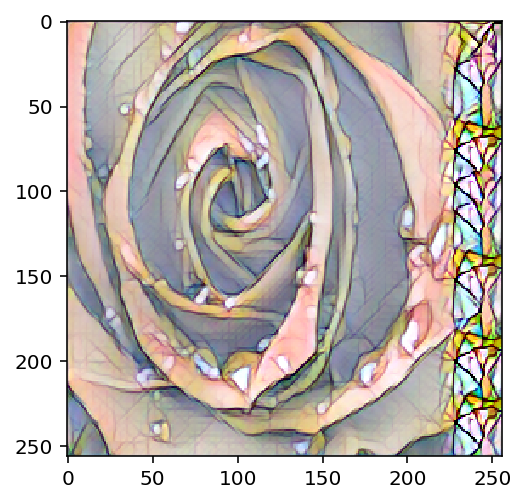

In [14]:
device = torch.device('cpu')
fwnet = ImfwNet()
fwnet.load_state_dict(torch.load("data/chap9/imfwnet_dict.pkl", map_location=device))

transform_content = fwnet(content)
## 可视化图像
plt.figure()
plt.imshow(im_convert(transform_content))
plt.show()

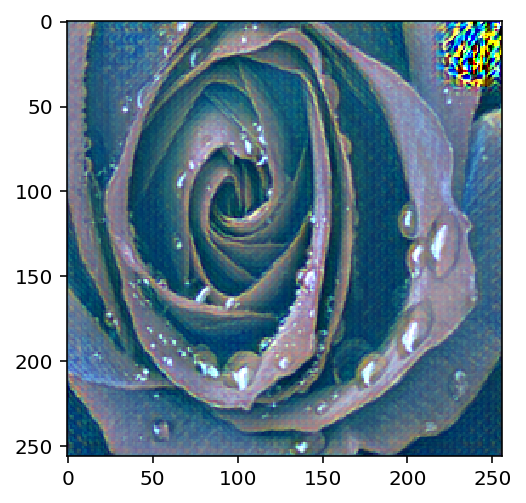

In [15]:
device = torch.device('cpu')
fwnet = ImfwNet()
fwnet.load_state_dict(torch.load("data/chap9/imfwnet_xingkong_dict.pkl", map_location=device))

transform_content = fwnet(content)
## 可视化图像
plt.figure()
plt.imshow(im_convert(transform_content))
plt.show()

content shape: torch.Size([1, 3, 400, 640])


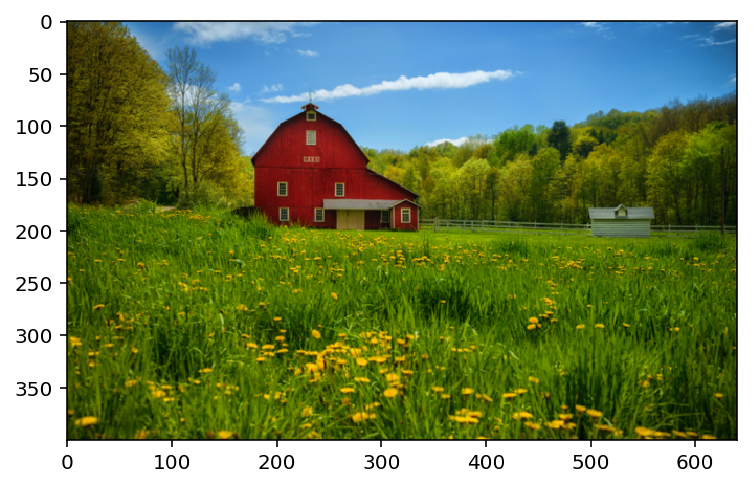

In [8]:
# 读取内容图像
content= load_image("data/chap9/tar58.png",shape = (400,640))
print("content shape:",content.shape)
## 可视化图像
plt.figure()
plt.imshow(im_convert(content))
plt.show()

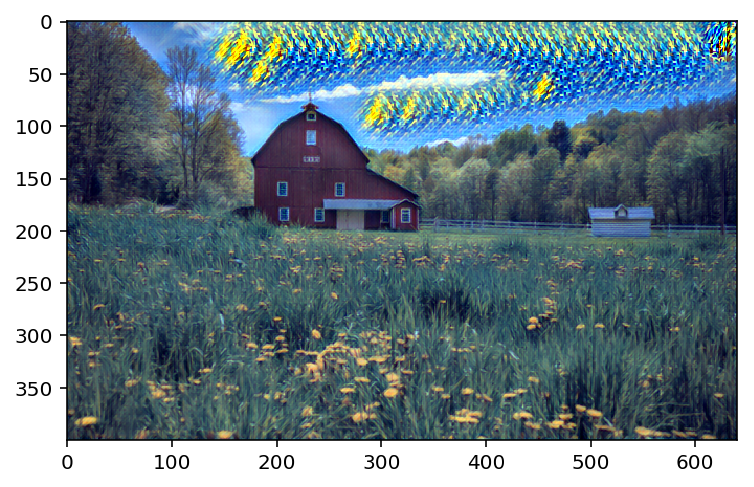

In [9]:
device = torch.device('cpu')
fwnet = ImfwNet()
fwnet.load_state_dict(torch.load("data/chap9/imfwnet_xingkong_dict.pkl", map_location=device))

transform_content = fwnet(content)
## 可视化图像
plt.figure()
plt.imshow(im_convert(transform_content))
plt.show()